This notebook is the second in the series from [Run or Walk project](https://github.com/vmalyi/run-or-walk/blob/master/README). 

In this notebook, multi-layer neural network will be trained and evaluated based on data from [Run or Walk Reduced dataset](https://www.kaggle.com/vmalyi/run-or-walk-reduced). Note that this *Run or Walk Final* dataset uses only the subset of data from the original [Run or Walk dataset](https://www.kaggle.com/vmalyi/run-or-walk).

See [Run or Walk Dataset Analysis and Visualization](https://www.kaggle.com/vmalyi/run-or-walk-data-analysis-and-visualization) notebook first in order to get first impression about the dataset used here.

## 1. Manage imports

In [11]:
import os
from datetime import datetime
import keras
import numpy
import pandas as pd
import shutil

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from numpy import argmax

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import os

## 2. Load Dataset

In [12]:

entries = os.listdir('axxis/')
file_extension = '.csv'
axxis = {'x':[],'y':[]}
for file in entries:
    df = pd.read_csv('axxis/'+file)
    #df = pd.read_csv('accel_x_final_dataset.csv')

    dataset = df.values

    X = dataset[:,0:46].astype(float) # sensor data
    Y = dataset[:,46].astype(int) # labels

    axxis['x'].append(X)
    axxis['y'].append(Y)
    #X = dataset[:,0:12].astype(float) # sensor data
    #Y = dataset[:,12].astype(int) # labels

## 3. Define Neural Network Model

Multi-layer neural network with 3 hidden layers 15 units each, all with *relu* activation function. 

Input layer consists of 12 units. Output layer consits of 2 units, representing *walk* and *run* activities predicted by the model.

In [13]:
def create_model():
    # Define model
    global model
    model = Sequential()
    model.add(Dense(15, input_dim=46, activation='relu'))
    #model.add(Dense(15, input_dim=12, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(6, activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## 4. Configure model callbacks including early stopping routine

In [14]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
loss_history = LossHistory()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20)

logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

## 5. Assemble classifier and train it

Baseline on test data: 28.75% (16.99%)
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       518
           1       0.69      0.54      0.60       276
           2       0.75      0.86      0.80       341
           3       0.88      0.86      0.87       382
           4       0.68      0.71      0.69       382
           5       0.98      0.99      0.98       326

    accuracy                           0.82      2225
   macro avg       0.81      0.80      0.80      2225
weighted avg       0.82      0.82      0.81      2225

F1 score: 0.815730
Baseline on test data: 28.97% (17.65%)
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       518
           1       0.74      0.66      0.69       276
           2       0.84      0.89      0.87       341
           3       0.93      0.91      0.92       382
           4       0.73      0.76      0.74       382
           5       1.00      1.00  

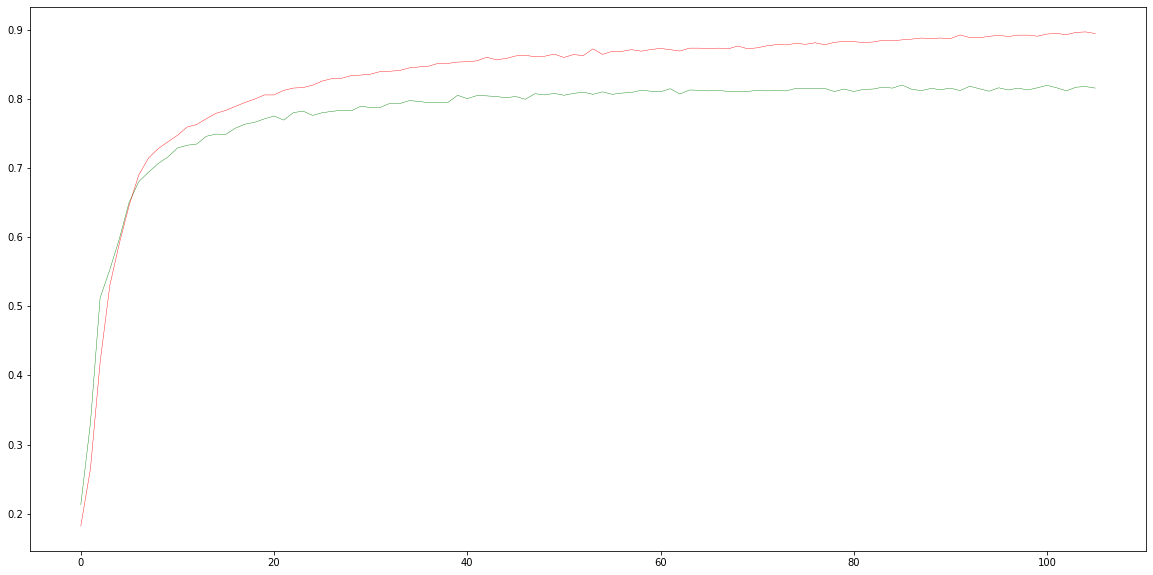

<Figure size 432x288 with 0 Axes>

/Users/nuno/IdeaProjects/ai_ping_pong/venv/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/nuno/IdeaProjects/ai_ping_pong/venv/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary class

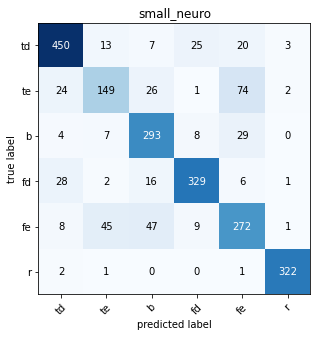

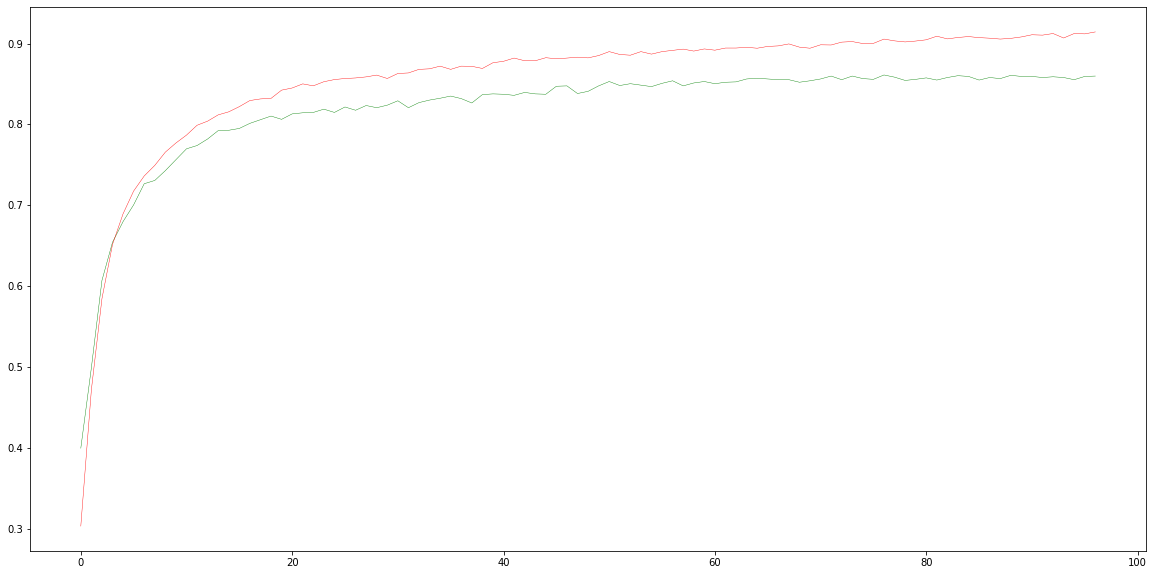

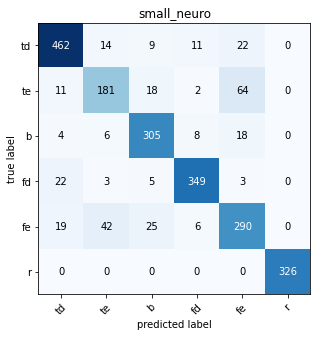

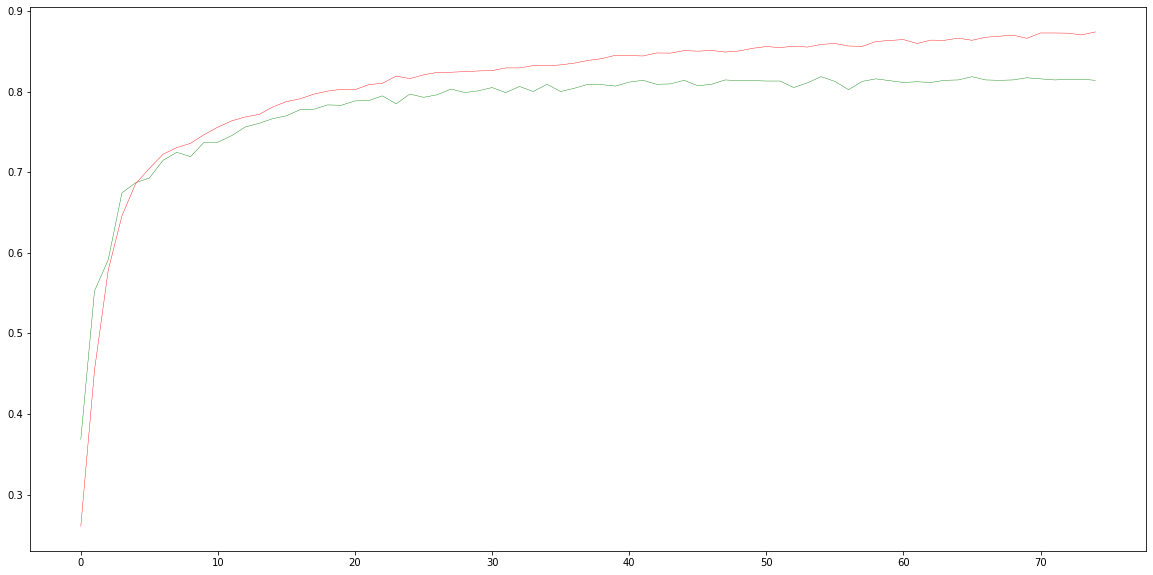

<Figure size 432x288 with 0 Axes>

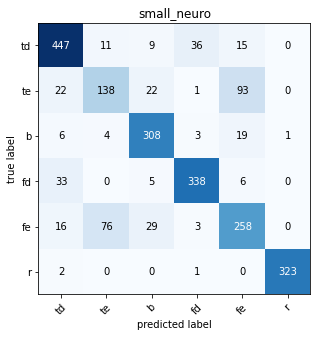

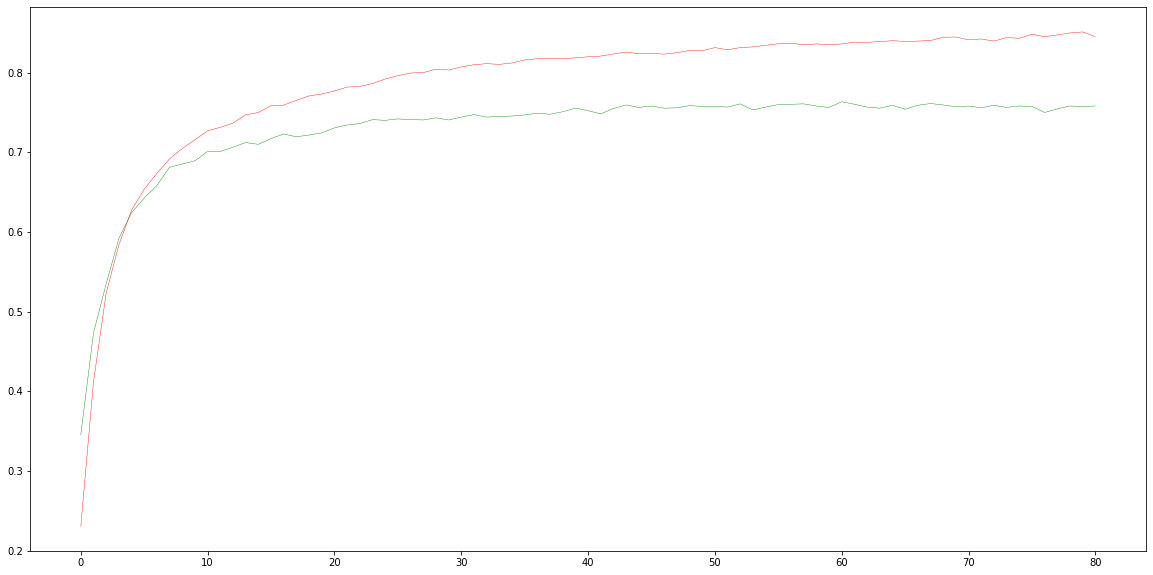

<Figure size 432x288 with 0 Axes>

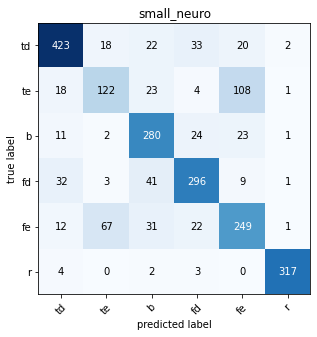

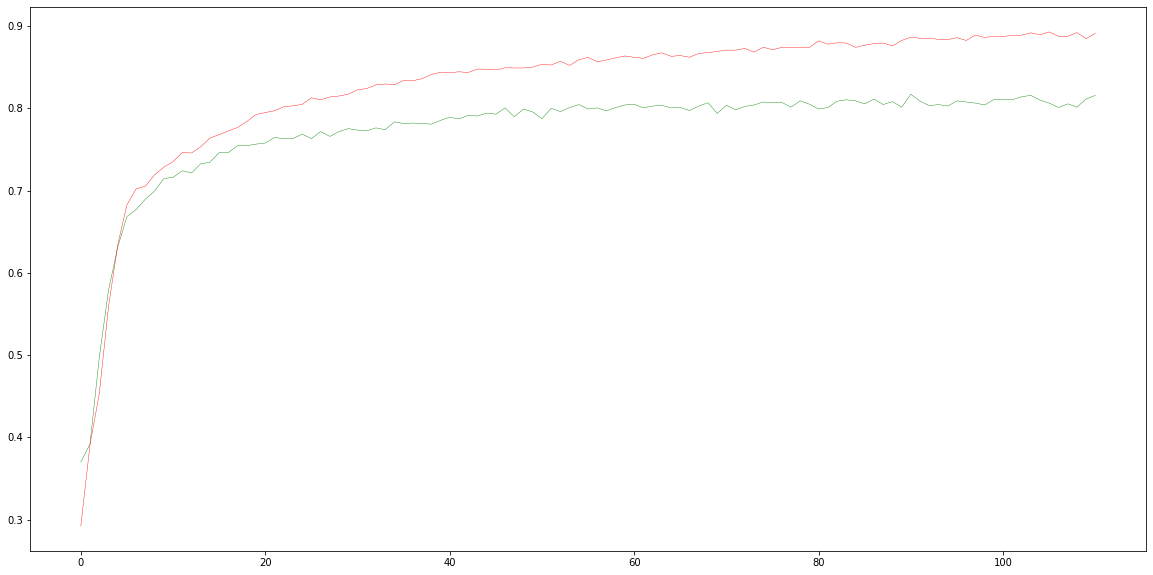

<Figure size 432x288 with 0 Axes>

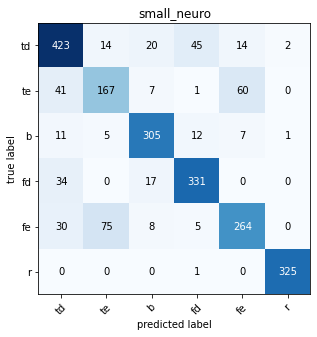

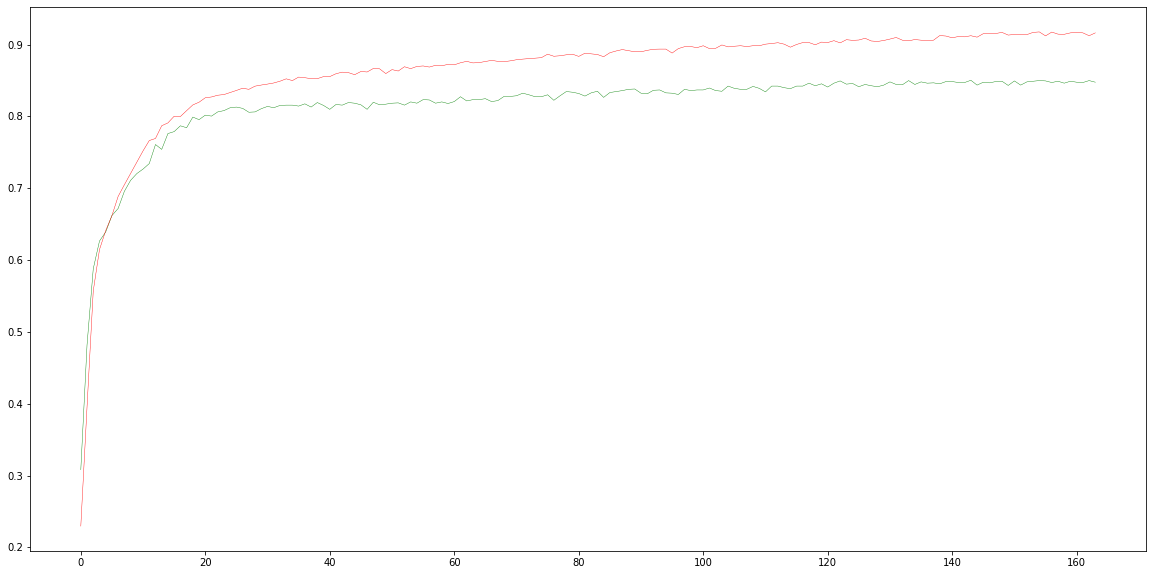

<Figure size 432x288 with 0 Axes>

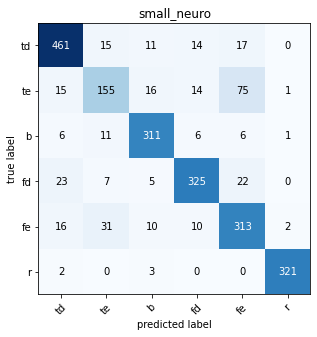

In [15]:
def confusion_matrix_and_stats(model, testX, testy):
        pred = model.predict(testX)
        y_true = argmax(testy, axis=1)

        from sklearn.metrics import confusion_matrix
        CM = confusion_matrix(y_true, pred, labels=[0,1, 2, 3, 4,5])
        from mlxtend.plotting import plot_confusion_matrix
        fig, ax = plot_confusion_matrix(conf_mat=CM, figsize=(10, 5),class_names=['td','te','b','fd','fe','r'])
        plt.title("small_neuro")
        plt.show()
        from sklearn.metrics import classification_report, accuracy_score, f1_score
        print(classification_report(y_true, pred))
        f1 = f1_score(y_true, pred,average='micro')
        print('F1 score: %f' % f1)




from keras.utils.np_utils import to_categorical
for index,value in enumerate(axxis['x']):
    X = axxis['x'][index]
    Y = axxis['y'][index]
    estimator = KerasClassifier(create_model, epochs=200, batch_size=100, verbose=False)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=5)
    Y_test = to_categorical(Y_test)

    results = estimator.fit(X_train, Y_train, callbacks=[loss_history, early_stopping,tensorboard_callback], validation_data=(X_test, Y_test))

    kfold = KFold(n_splits=10, shuffle=True, random_state=5)
    cv_results = cross_val_score(estimator, X_test, Y_test, cv=kfold)
    print("Baseline on test data: %.2f%% (%.2f%%)" % (cv_results.mean()*100, cv_results.std()*100))

    import matplotlib.pyplot as plt

    figsize = (20, 10)
    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(results.history['val_accuracy'], linewidth=0.4, color="green")
    ax.plot(results.history['accuracy'], linewidth=0.4, color="red")
    plt.figure(num=index)
    plt.show()

    confusion_matrix_and_stats(estimator,X_test,Y_test)


